In [ ]:
# Colab link: https://colab.research.google.com/drive/1Tzjm4zKZgtYW-xIM0IqBqs7gpB7zlM12?usp=sharing

#Fraud in credit card transaction detection


This project aims to experiment and develop a fraud detection ML model.

**Problem Statement:** Identify fraudulent credit card transfers.



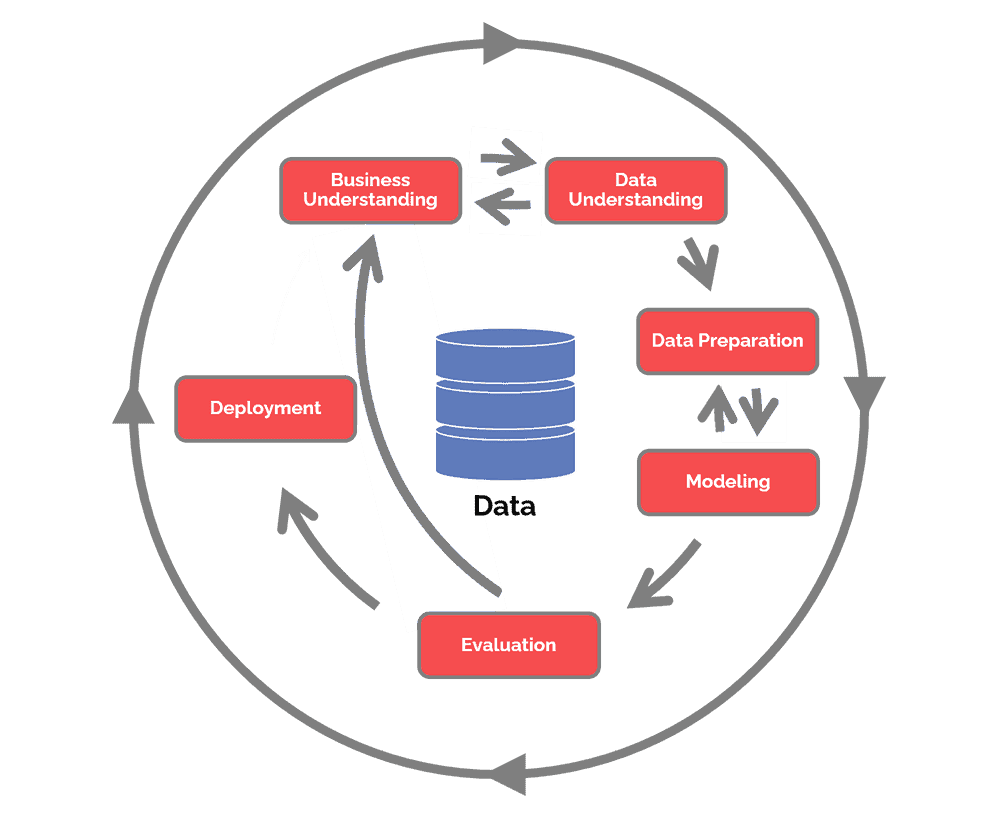


Import from Kaggle

In [1]:
#@title Kaggle imports

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'credit-card-fraud-prediction:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F4578400%2F7815453%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240413%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240413T191752Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3Db16c7e16e815662614ae6b85eedb721cc941e5d2d4d0c0d49b94d4f64a44a9b0a5fba66a5ea7af0928f805b0beff9ef9220be7d6073b95527ce4f61ed598aacb3742b39a6a5880eca0c43ca7f38c69a498d62b87bc225416c4edf85d94c07c33740e7838159e9b4494f71c11371d625df571b70cdc290e6f1ac7be781eec60f44995de1055b0134c403e65fa892d2cfc0bd484fa1704aa118e0745dbe8836cd692d61bf4e2cc874133edba48da0bec10e4271a5f5b5af3e183663853007e7bc5f4968a65f6d8a96aaed6bca5bd040acd8ed78dc7555bace8ac45824f94c385b4c1e95d04773b2d750c15aa7b224ed616526e348a9b03a9f245c11471c5be0be5'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 59483217 bytes downloaded
Downloaded and uncompressed: credit-card-fraud-prediction
Data source import complete.


#Dataset Description

This dataset contains information about credit card transactions and can be used for fraud detection purposes. It has 555,719 transactions with 22 attributes, including a mix of categorical and numerical data. There are no missing values present.

**Target Variable:**

Is_fraud (1 = Fraudulent, 0 = Legitimate)

**Potential Correlations:**

**Transaction Amount (Amt)**:

Higher transaction amounts might be more likely to be fraudulent,
especially if they deviate significantly from a customer's usual spending habits.

**Cardholder Location** (Lat, Long, City, State, Merch_lat, Merch_long,):

Transactions occurring far from a cardholder's usual location (based on past transactions or billing address) could indicate fraud.

**Time-based features** (Trans_date_trans_time, Unix_time):

Fraudulent transactions might be more frequent at unusual times,
like late at night or on weekends.

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from imblearn.under_sampling import RandomUnderSampler


from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder


from sklearn.naive_bayes import GaussianNB

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.svm import OneClassSVM
from sklearn.svm import SVC



from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/credit-card-fraud-prediction/fraud test.csv


In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
data = pd.read_csv('/kaggle/input/credit-card-fraud-prediction/fraud test.csv')
data

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,21/06/2020 12:14,2.291160e+15,fraud_Kirlin and Sons,personal_care,2.86,Jeff,Elliott,M,351 Darlene Green,...,33.9659,-80.9355,333497,Mechanical engineer,19/03/1968,2da90c7d74bd46a0caf3777415b3ebd3,1371816865,33.986391,-81.200714,0
1,1,21/06/2020 12:14,3.573030e+15,fraud_Sporer-Keebler,personal_care,29.84,Joanne,Williams,F,3638 Marsh Union,...,40.3207,-110.4360,302,"Sales professional, IT",17/01/1990,324cc204407e99f51b0d6ca0055005e7,1371816873,39.450498,-109.960431,0
2,2,21/06/2020 12:14,3.598220e+15,"fraud_Swaniawski, Nitzsche and Welch",health_fitness,41.28,Ashley,Lopez,F,9333 Valentine Point,...,40.6729,-73.5365,34496,"Librarian, public",21/10/1970,c81755dbbbea9d5c77f094348a7579be,1371816893,40.495810,-74.196111,0
3,3,21/06/2020 12:15,3.591920e+15,fraud_Haley Group,misc_pos,60.05,Brian,Williams,M,32941 Krystal Mill Apt. 552,...,28.5697,-80.8191,54767,Set designer,25/07/1987,2159175b9efe66dc301f149d3d5abf8c,1371816915,28.812398,-80.883061,0
4,4,21/06/2020 12:15,3.526830e+15,fraud_Johnston-Casper,travel,3.19,Nathan,Massey,M,5783 Evan Roads Apt. 465,...,44.2529,-85.0170,1126,Furniture designer,06/07/1955,57ff021bd3f328f8738bb535c302a31b,1371816917,44.959148,-85.884734,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
555714,555714,31/12/2020 23:59,3.056060e+13,fraud_Reilly and Sons,health_fitness,43.77,Michael,Olson,M,558 Michael Estates,...,40.4931,-91.8912,519,Town planner,13/02/1966,9b1f753c79894c9f4b71f04581835ada,1388534347,39.946837,-91.333331,0
555715,555715,31/12/2020 23:59,3.556610e+15,fraud_Hoppe-Parisian,kids_pets,111.84,Jose,Vasquez,M,572 Davis Mountains,...,29.0393,-95.4401,28739,Futures trader,27/12/1999,2090647dac2c89a1d86c514c427f5b91,1388534349,29.661049,-96.186633,0
555716,555716,31/12/2020 23:59,6.011720e+15,fraud_Rau-Robel,kids_pets,86.88,Ann,Lawson,F,144 Evans Islands Apt. 683,...,46.1966,-118.9017,3684,Musician,29/11/1981,6c5b7c8add471975aa0fec023b2e8408,1388534355,46.658340,-119.715054,0
555717,555717,31/12/2020 23:59,4.079770e+12,fraud_Breitenberg LLC,travel,7.99,Eric,Preston,M,7020 Doyle Stream Apt. 951,...,44.6255,-116.4493,129,Cartographer,15/12/1965,14392d723bb7737606b2700ac791b7aa,1388534364,44.470525,-117.080888,0


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 555719 entries, 0 to 555718
Data columns (total 23 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Unnamed: 0             555719 non-null  int64  
 1   trans_date_trans_time  555719 non-null  object 
 2   cc_num                 555719 non-null  float64
 3   merchant               555719 non-null  object 
 4   category               555719 non-null  object 
 5   amt                    555719 non-null  float64
 6   first                  555719 non-null  object 
 7   last                   555719 non-null  object 
 8   gender                 555719 non-null  object 
 9   street                 555719 non-null  object 
 10  city                   555719 non-null  object 
 11  state                  555719 non-null  object 
 12  zip                    555719 non-null  int64  
 13  lat                    555719 non-null  float64
 14  long                   555719 non-nu

In [6]:
data.describe()

,Unnamed: 0,cc_num,amt,zip,lat,long,city_pop,unix_time,merch_lat,merch_long,is_fraud
count,555719.000000,5.557190e+05,555719.000000,555719.000000,555719.000000,555719.000000,5.557190e+05,5.557190e+05,555719.000000,555719.000000,555719.000000
mean,277859.000000,4.178387e+17,69.392810,48842.628015,38.543253,-90.231325,8.822189e+04,1.380679e+09,38.542798,-90.231380,0.003860
std,160422.401459,1.309837e+18,156.745941,26855.283328,5.061336,13.721780,3.003909e+05,5.201104e+06,5.095829,13.733071,0.062008
min,0.000000,6.041621e+10,1.000000,1257.000000,20.027100,-165.672300,2.300000e+01,1.371817e+09,19.027422,-166.671575,0.000000
25%,138929.500000,1.800430e+14,9.630000,26292.000000,34.668900,-96.798000,7.410000e+02,1.376029e+09,34.755302,-96.905129,0.000000
50%,277859.000000,3.521420e+15,47.290000,48174.000000,39.371600,-87.476900,2.408000e+03,1.380762e+09,39.376593,-87.445204,0.000000
75%,416788.500000,4.635330e+15,83.010000,72011.000000,41.894800,-80.175200,1.968500e+04,1.385867e+09,41.954163,-80.264637,0.000000
max,555718.000000,4.992350e+18,22768.110000,99921.000000,65.689900,-67.950300,2.906700e+06,1.388534e+09,66.679297,-66.952026,1.000000


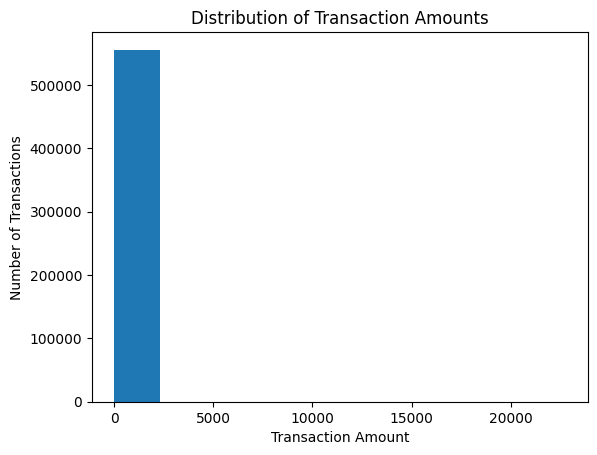

In [7]:
plt.hist(data['amt'])
plt.xlabel('Transaction Amount')
plt.ylabel('Number of Transactions')
plt.title('Distribution of Transaction Amounts')
plt.show()

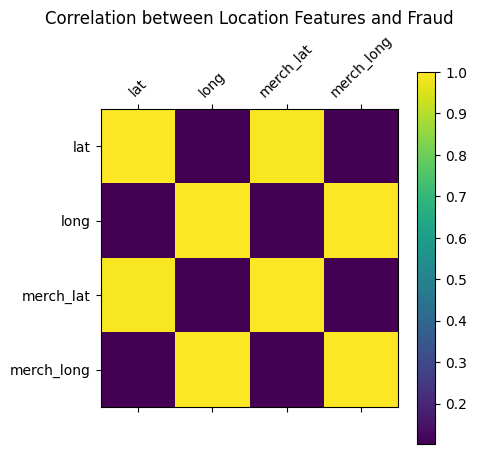

In [8]:
correlation = data[['lat', 'long', 'merch_lat', 'merch_long']].corr(method='spearman')


plt.matshow(correlation)
plt.xticks(range(len(correlation.columns)), correlation.columns, rotation=45)
plt.yticks(range(len(correlation.columns)), correlation.columns)
plt.colorbar()
plt.title('Correlation between Location Features and Fraud')
plt.show()

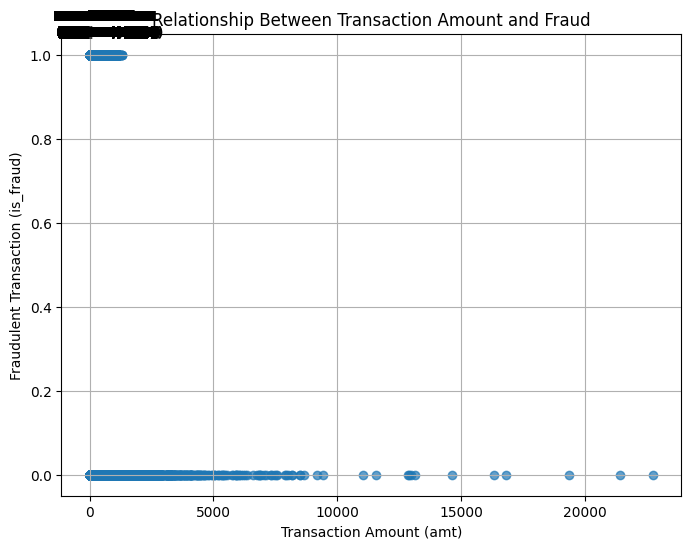

In [9]:
plt.figure(figsize=(8, 6))
plt.scatter(data['amt'], data['is_fraud'], alpha=0.7)  # Adjust alpha for transparency
plt.xlabel('Transaction Amount (amt)')
plt.ylabel('Fraudulent Transaction (is_fraud)')
plt.title('Relationship Between Transaction Amount and Fraud')
plt.grid(True)

fraud_indices = data[data['is_fraud'] == 1].index
for i in fraud_indices:
  plt.annotate(f"Fraudulent\n($ {data.loc[i, 'amt']:.2f})", (data.loc[i, 'amt'], 1.01), textcoords="offset points", xytext=(0, 10), ha='center')

plt.show()


In [10]:
data.columns

Index(['Unnamed: 0', 'trans_date_trans_time', 'cc_num', 'merchant', 'category',
       'amt', 'first', 'last', 'gender', 'street', 'city', 'state', 'zip',
       'lat', 'long', 'city_pop', 'job', 'dob', 'trans_num', 'unix_time',
       'merch_lat', 'merch_long', 'is_fraud'],
      dtype='object')

In [11]:
print("Missing values summary:")
print(data.isnull().sum())
print(len(data))

Missing values summary:
Unnamed: 0               0
trans_date_trans_time    0
cc_num                   0
merchant                 0
category                 0
amt                      0
first                    0
last                     0
gender                   0
street                   0
city                     0
state                    0
zip                      0
lat                      0
long                     0
city_pop                 0
job                      0
dob                      0
trans_num                0
unix_time                0
merch_lat                0
merch_long               0
is_fraud                 0
dtype: int64
555719


In [12]:
features_to_drop = [ 'dob', 'first', 'last', 'trans_num', 'cc_num']

data.drop(features_to_drop, axis=1)

,Unnamed: 0,trans_date_trans_time,merchant,category,amt,gender,street,city,state,zip,lat,long,city_pop,job,unix_time,merch_lat,merch_long,is_fraud
0,0,21/06/2020 12:14,fraud_Kirlin and Sons,personal_care,2.86,M,351 Darlene Green,Columbia,SC,29209,33.9659,-80.9355,333497,Mechanical engineer,1371816865,33.986391,-81.200714,0
1,1,21/06/2020 12:14,fraud_Sporer-Keebler,personal_care,29.84,F,3638 Marsh Union,Altonah,UT,84002,40.3207,-110.4360,302,"Sales professional, IT",1371816873,39.450498,-109.960431,0
2,2,21/06/2020 12:14,"fraud_Swaniawski, Nitzsche and Welch",health_fitness,41.28,F,9333 Valentine Point,Bellmore,NY,11710,40.6729,-73.5365,34496,"Librarian, public",1371816893,40.495810,-74.196111,0
3,3,21/06/2020 12:15,fraud_Haley Group,misc_pos,60.05,M,32941 Krystal Mill Apt. 552,Titusville,FL,32780,28.5697,-80.8191,54767,Set designer,1371816915,28.812398,-80.883061,0
4,4,21/06/2020 12:15,fraud_Johnston-Casper,travel,3.19,M,5783 Evan Roads Apt. 465,Falmouth,MI,49632,44.2529,-85.0170,1126,Furniture designer,1371816917,44.959148,-85.884734,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
555714,555714,31/12/2020 23:59,fraud_Reilly and Sons,health_fitness,43.77,M,558 Michael Estates,Luray,MO,63453,40.4931,-91.8912,519,Town planner,1388534347,39.946837,-91.333331,0
555715,555715,31/12/2020 23:59,fraud_Hoppe-Parisian,kids_pets,111.84,M,572 Davis Mountains,Lake Jackson,TX,77566,29.0393,-95.4401,28739,Futures trader,1388534349,29.661049,-96.186633,0
555716,555716,31/12/2020 23:59,fraud_Rau-Robel,kids_pets,86.88,F,144 Evans Islands Apt. 683,Burbank,WA,99323,46.1966,-118.9017,3684,Musician,1388534355,46.658340,-119.715054,0
555717,555717,31/12/2020 23:59,fraud_Breitenberg LLC,travel,7.99,M,7020 Doyle Stream Apt. 951,Mesa,ID,83643,44.6255,-116.4493,129,Cartographer,1388534364,44.470525,-117.080888,0


In [13]:
# feature generatiion
data['day_of_week'] = pd.to_datetime(data['trans_date_trans_time']).dt.dayofweek  # (0-6)
data['hour_of_day'] = pd.to_datetime(data['trans_date_trans_time']).dt.hour
data['is_weekend'] = (data['day_of_week'] >= 5).astype(int)  #  (1/0)
data['month'] = pd.to_datetime(data['trans_date_trans_time']).dt.month  # (1-12)

data.drop(['trans_date_trans_time'], axis=1)

data
data.columns

Index(['Unnamed: 0', 'trans_date_trans_time', 'cc_num', 'merchant', 'category',
       'amt', 'first', 'last', 'gender', 'street', 'city', 'state', 'zip',
       'lat', 'long', 'city_pop', 'job', 'dob', 'trans_num', 'unix_time',
       'merch_lat', 'merch_long', 'is_fraud', 'day_of_week', 'hour_of_day',
       'is_weekend', 'month'],
      dtype='object')

The section below is generated code to calculate a new feature.

In [14]:
def haversine_distance(lat1, lon1, lat2, lon2):
  from math import radians, sin, cos, acos, sqrt
  R = 6371

  lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])


  dlon = lon2 - lon1
  dlat = lat2 - lat1
  a = sin(dlat/2) * sin(dlat/2) + cos(radians(lat1)) * cos(radians(lat2)) * sin(dlon/2) * sin(dlon/2)
  c = 2 * acos(sqrt(a))
  distance = R * c

  return distance

data['distance_from_billing_address'] = data.apply(lambda row: haversine_distance(row['lat'], row['long'], row['merch_lat'], row['merch_long']), axis=1)
data['average_transaction'] = data.groupby('cc_num')['amt'].transform('mean')

data
data.columns

Index(['Unnamed: 0', 'trans_date_trans_time', 'cc_num', 'merchant', 'category',
       'amt', 'first', 'last', 'gender', 'street', 'city', 'state', 'zip',
       'lat', 'long', 'city_pop', 'job', 'dob', 'trans_num', 'unix_time',
       'merch_lat', 'merch_long', 'is_fraud', 'day_of_week', 'hour_of_day',
       'is_weekend', 'month', 'distance_from_billing_address',
       'average_transaction'],
      dtype='object')

In [15]:
data['average_transaction'] = data.groupby('cc_num')['amt'].transform('mean')
data

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,unix_time,merch_lat,merch_long,is_fraud,day_of_week,hour_of_day,is_weekend,month,distance_from_billing_address,average_transaction
0,0,21/06/2020 12:14,2.291160e+15,fraud_Kirlin and Sons,personal_care,2.86,Jeff,Elliott,M,351 Darlene Green,...,1371816865,33.986391,-81.200714,0,6,12,1,6,19985.510029,61.893062
1,1,21/06/2020 12:14,3.573030e+15,fraud_Sporer-Keebler,personal_care,29.84,Joanne,Williams,F,3638 Marsh Union,...,1371816873,39.450498,-109.960431,0,6,12,1,6,19904.819059,53.596523
2,2,21/06/2020 12:14,3.598220e+15,"fraud_Swaniawski, Nitzsche and Welch",health_fitness,41.28,Ashley,Lopez,F,9333 Valentine Point,...,1371816893,40.495810,-74.196111,0,6,12,1,6,19939.149393,83.053812
3,3,21/06/2020 12:15,3.591920e+15,fraud_Haley Group,misc_pos,60.05,Brian,Williams,M,32941 Krystal Mill Apt. 552,...,1371816915,28.812398,-80.883061,0,6,12,1,6,19987.178635,59.207526
4,4,21/06/2020 12:15,3.526830e+15,fraud_Johnston-Casper,travel,3.19,Nathan,Massey,M,5783 Evan Roads Apt. 465,...,1371816917,44.959148,-85.884734,0,6,12,1,6,19890.686129,55.274501
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
555714,555714,31/12/2020 23:59,3.056060e+13,fraud_Reilly and Sons,health_fitness,43.77,Michael,Olson,M,558 Michael Estates,...,1388534347,39.946837,-91.333331,0,3,23,0,12,19928.270750,72.595446
555715,555715,31/12/2020 23:59,3.556610e+15,fraud_Hoppe-Parisian,kids_pets,111.84,Jose,Vasquez,M,572 Davis Mountains,...,1388534349,29.661049,-96.186633,0,3,23,0,12,19907.058780,46.529792
555716,555716,31/12/2020 23:59,6.011720e+15,fraud_Rau-Robel,kids_pets,86.88,Ann,Lawson,F,144 Evans Islands Apt. 683,...,1388534355,46.658340,-119.715054,0,3,23,0,12,19911.095852,92.682790
555717,555717,31/12/2020 23:59,4.079770e+12,fraud_Breitenberg LLC,travel,7.99,Eric,Preston,M,7020 Doyle Stream Apt. 951,...,1388534364,44.470525,-117.080888,0,3,23,0,12,19942.780361,58.129411


In [16]:
print(len(data))
fraud_count = data[data['is_fraud'] == 1].shape[0]
legitimate_count = data[data['is_fraud'] == 0].shape[0]

print("Number of fraudulent transactions:", fraud_count)
print("Number of legitimate transactions:", legitimate_count)

555719
Number of fraudulent transactions: 2145
Number of legitimate transactions: 553574


In [17]:
drop_features = ['dob', 'first', 'last', 'trans_num', 'cc_num']
data = data.drop(drop_features, axis=1)

In [18]:
def identify_non_encoded_features(data):
  categorical_cols = []
  for col in data.columns:
    if data[col].dtype == 'object':
      if pd.api.types.is_string_dtype(data[col]) and not data[col].hasnans:
        categorical_cols.append(col)

  return categorical_cols

non_encoded_features = identify_non_encoded_features(data.copy())
print("Non-encoded features:", non_encoded_features)

Non-encoded features: ['trans_date_trans_time', 'merchant', 'category', 'gender', 'street', 'city', 'state', 'job']


In [19]:
class_counts = data['is_fraud'].value_counts()

print(class_counts)

is_fraud
0    553574
1      2145
Name: count, dtype: int64


In [20]:
encode_cols = ['merchant', 'category', 'gender', 'street', 'city', 'state', 'job']
numeric_cols = []
for col in data.columns:
  if col not in encode_cols and col != 'trans_date_trans_time' and col != 'is_fraud':
    numeric_cols.append(col)
y = data['is_fraud']
categorical_encoder = OrdinalEncoder()
X_train_categorical = categorical_encoder.fit_transform(data[encode_cols])
X_test_categorical = categorical_encoder.transform(data[encode_cols])

data = np.concatenate((data[numeric_cols], X_test_categorical), axis=1)
data


array([[0.00000e+00, 2.86000e+00, 2.92090e+04, ..., 1.57000e+02,
        3.90000e+01, 2.75000e+02],
       [1.00000e+00, 2.98400e+01, 8.40020e+04, ..., 1.60000e+01,
        4.30000e+01, 3.92000e+02],
       [2.00000e+00, 4.12800e+01, 1.17100e+04, ..., 6.10000e+01,
        3.30000e+01, 2.59000e+02],
       ...,
       [5.55716e+05, 8.68800e+01, 9.93230e+04, ..., 1.04000e+02,
        4.60000e+01, 2.94000e+02],
       [5.55717e+05, 7.99000e+00, 8.36430e+04, ..., 4.76000e+02,
        1.20000e+01, 5.80000e+01],
       [5.55718e+05, 3.81300e+01, 7.30340e+04, ..., 2.24000e+02,
        3.50000e+01, 2.76000e+02]])

In [21]:
X = data

We used three different machine learning models to try and solve the problem of detecting credit card fraud:

**Logistic Regression:** This model looks at the data and calculates the chances of a transaction being fraudulent. It does this by figuring out the best values for its calculations that match up with what it sees in the data.


**Decision Trees:** This approach splits the data up into branches to map out different transaction outcomes. Each split in the tree helps make clear decisions about the nature of a transaction.


**Random Forests:** This model uses a lot of decision trees that each give their take on the data, and then it picks the most common outcome from all the trees. It's like getting a second, third, and many more opinions before making a final decision.

**GaussianNB**: Estimates fraud chance by assuming features (amount, location, etc.) are independent and calculates the probability of each feature being fraudulent based on past data. It then picks the class (fraudulent or legitimate) with the highest overall probability.

Each model uses different math and statistics ideas, like understanding chances for Logistic Regression, how to gain the most information from data for Decision Trees, and how to best use many models at once for Random Forests

In [22]:
acc = []
rec = []

rus = RandomUnderSampler(sampling_strategy='majority')
def train_iteration_1(model):
  for i in range(100):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=i)

    X_train_resampled, y_train_resampled = rus.fit_resample(X_train, y_train)


    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_resampled)
    X_test_scaled = scaler.transform(X_test)

    model_lr_std = model.fit(X_train_scaled, y_train_resampled)
    y_pred = model_lr_std.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)

    acc.append(accuracy)
    rec.append(recall)

  print("Accuracy:", sum(acc) / len(acc))
  print("Recall:", sum(rec)/len(rec))

for model in [DecisionTreeClassifier(), LogisticRegression(), RandomForestClassifier(), GaussianNB()]:
  print(f'Train eval for {model} \n')
  train_iteration_1(model)


Train eval for DecisionTreeClassifier() 

Accuracy: 0.9883889368746851
Recall: 0.0025809847264636476
Train eval for LogisticRegression() 

Accuracy: 0.4961229126178651
Recall: 0.5012904923632319
Train eval for RandomForestClassifier() 

Accuracy: 0.6517854315122725
Recall: 0.3413824018711153
Train eval for GaussianNB() 

Accuracy: 0.7378748515439431
Recall: 0.25603680140333646


The findings in the above evaluation shows that there has been a data leakage in the steps used.
The steps used:



1. Handle missing values
2. Generate features
3. Encode features
4. Split in to test set and train set
5. Sample the train set
6. Train the model
7. Evaluate the model


The major problem here could be because we are encoding the entire dataset before we are splitting the data. Which is basically making the model "peek" for the answer before giving it the test. This means we have to do encoding after splitting and see if it improves our model.


In [23]:

'''
INVESTIGATION

This stage investigated if the bad models are a result of the type of scaler being used.
'''

Acc_st = []
Recall_st = []

Acc_mm = []
Recall_mm = []


for i in range(10):
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=i)

  scaler = StandardScaler()
  X_train_scaled = scaler.fit_transform(X_train)
  X_test_scaled = scaler.transform(X_test)

  model_lr_std = LogisticRegression().fit(X_train_scaled, y_train)
  y_pred = model_lr_std.predict(X_test)

  accuracy = accuracy_score(y_test, y_pred)
  recall = recall_score(y_test, y_pred)


  Acc_st.append(accuracy)
  Recall_st.append(recall)



for i in range(10):
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=i)

  scaler = MinMaxScaler(feature_range=(0, 1))
  X_train_normalized = scaler.fit_transform(X_train)
  X_test_normalized = scaler.transform(X_test)


  model_lr_norm = LogisticRegression().fit(X_train_normalized, y_train)
  y_pred = model_lr_norm.predict(X_test)


  accuracy = accuracy_score(y_test, y_pred)
  recall = recall_score(y_test, y_pred)


  Acc_mm.append(accuracy)
  Recall_mm.append(recall)




print("Accuracy St", sum(Acc_st) / len(Acc_st))
print("Recall St", sum(Recall_st) / len(Recall_st))
print("Accuracy mm", sum(Acc_mm) / len(Acc_mm))
print("Recall mm", sum(Recall_mm) / len(Recall_mm))

'''
This finding shows us that the type of normalization we do is not affecting the
model's performance. Which means we can choose any one of them.

'''


Accuracy St 0.0038751529547254014
Recall St 1.0
Accuracy mm 0.0038751529547254014
Recall mm 1.0


"\nThis finding shows us that the type of normalization we do is not affecting the\nmodel's performance. Which means we can choose any one of them.\n\n"

#Iteration 2

This section will try to get the accuracy and the recall better by doing the following steps.


1. Load the data
2. Drop not important features and generate features
3. Sample the data (under sampler)
4. Split the data in to test and train set
5. Encode the train set separately to avoid data leakage
6. Train the models
7. Evaluate the models



In [24]:
from imblearn.under_sampling import RandomUnderSampler


df = pd.read_csv("/kaggle/input/credit-card-fraud-prediction/fraud test.csv")


target_variable = 'is_fraud'
features_to_drop = [ 'dob', 'first', 'last', 'trans_num', 'cc_num', 'merchant', 'street', 'city', 'state', 'category', 'job']
df = df.drop(features_to_drop, axis=1)


In [25]:
print("Missing values summary:")
print(df.isnull().sum())
print(len(df))

Missing values summary:
Unnamed: 0               0
trans_date_trans_time    0
amt                      0
gender                   0
zip                      0
lat                      0
long                     0
city_pop                 0
unix_time                0
merch_lat                0
merch_long               0
is_fraud                 0
dtype: int64
555719


In [26]:
df = df.dropna(axis=1)
df

,Unnamed: 0,trans_date_trans_time,amt,gender,zip,lat,long,city_pop,unix_time,merch_lat,merch_long,is_fraud
0,0,21/06/2020 12:14,2.86,M,29209,33.9659,-80.9355,333497,1371816865,33.986391,-81.200714,0
1,1,21/06/2020 12:14,29.84,F,84002,40.3207,-110.4360,302,1371816873,39.450498,-109.960431,0
2,2,21/06/2020 12:14,41.28,F,11710,40.6729,-73.5365,34496,1371816893,40.495810,-74.196111,0
3,3,21/06/2020 12:15,60.05,M,32780,28.5697,-80.8191,54767,1371816915,28.812398,-80.883061,0
4,4,21/06/2020 12:15,3.19,M,49632,44.2529,-85.0170,1126,1371816917,44.959148,-85.884734,0
...,...,...,...,...,...,...,...,...,...,...,...,...
555714,555714,31/12/2020 23:59,43.77,M,63453,40.4931,-91.8912,519,1388534347,39.946837,-91.333331,0
555715,555715,31/12/2020 23:59,111.84,M,77566,29.0393,-95.4401,28739,1388534349,29.661049,-96.186633,0
555716,555716,31/12/2020 23:59,86.88,F,99323,46.1966,-118.9017,3684,1388534355,46.658340,-119.715054,0
555717,555717,31/12/2020 23:59,7.99,M,83643,44.6255,-116.4493,129,1388534364,44.470525,-117.080888,0


In [27]:

df['trans_datetime'] = pd.to_datetime(df['trans_date_trans_time'], format='%d/%m/%Y %H:%M')

df['day_of_week'] = df['trans_datetime'].dt.weekday
df['transaction_hour'] = df['trans_datetime'].dt.hour
df['is_weekend'] = df['day_of_week'].isin([5, 6])

df = df.drop(columns=['trans_date_trans_time','gender', 'Unnamed: 0', 'trans_datetime'])
features = [col for col in df.columns if col not in target_variable and col not in features_to_drop]
print(df.head(0))

X = df[features]
y = df[target_variable]
rus = RandomUnderSampler(sampling_strategy='majority')
X_resampled, y_resampled = rus.fit_resample(X, y)

print("Dataframe after undersampling:")
print(X_resampled.columns)

Empty DataFrame
Columns: [amt, zip, lat, long, city_pop, unix_time, merch_lat, merch_long, is_fraud, day_of_week, transaction_hour, is_weekend]
Index: []
Dataframe after undersampling:
Index(['amt', 'zip', 'lat', 'long', 'city_pop', 'unix_time', 'merch_lat',
       'merch_long', 'day_of_week', 'transaction_hour', 'is_weekend'],
      dtype='object')


In [28]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, f1_score

def train_no_sample_2(model):
  acc = []
  rec = []
  prec = []
  f1 = []

  for i in range(200):
    X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.4, random_state=i)

    numerical_columns = [col for col in X_train.columns if X_train[col].dtype in ['int64', 'float64']]

    nominal = [col for col in X_train.columns if X_train[col].dtype == 'object']


    categorical_encoder = OrdinalEncoder()
    X_train_categorical = categorical_encoder.fit_transform(X_train[nominal])
    X_test_categorical = categorical_encoder.transform(X_test[nominal])

    X_train = np.concatenate((X_train[numerical_columns], X_train_categorical), axis=1)
    X_test = np.concatenate((X_test[numerical_columns], X_test_categorical), axis=1)

    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    f1_s = f1_score(y_test, y_pred)
    acc.append(accuracy)
    rec.append(recall)
    prec.append(precision)
    f1.append(f1_s)

  print("Accuracy:", sum(acc) / len(acc))
  print("Recall:", sum(rec)/len(rec))
  print("Precision:", sum(prec)/len(prec))
  print("F1 Score:", sum(f1)/len(f1))

models = [DecisionTreeClassifier(), LogisticRegression(), RandomForestClassifier(), GaussianNB()]

for model in models:
  print(f'Train eval for {model} \n')
  train_no_sample_2(model)

Train eval for DecisionTreeClassifier() 

Accuracy: 0.8706934731934727
Recall: 0.8793585604306583
Precision: 0.864322827015326
F1 Score: 0.8716630626218363
Train eval for LogisticRegression() 

Accuracy: 0.5056177156177157
Recall: 0.7159291077541832
Precision: 0.406435713147059
F1 Score: 0.5135538707861641
Train eval for RandomForestClassifier() 

Accuracy: 0.9210343822843821
Recall: 0.9060128980243656
Precision: 0.9340080135211931
F1 Score: 0.9197379801751233
Train eval for GaussianNB() 

Accuracy: 0.8283245920745916
Recall: 0.6832760595262044
Precision: 0.9622749168184176
F1 Score: 0.7989505451728437


In [29]:
from sklearn.model_selection import cross_val_score


numerical_columns = [col for col in X_resampled.columns if X_resampled[col].dtype in ['int64', 'float64']]

nominal = [col for col in X_resampled.columns if X_resampled[col].dtype == 'object']

categorical_encoder = OrdinalEncoder()
X_categorical = categorical_encoder.fit_transform(X_resampled[nominal])
X_categorical = categorical_encoder.transform(X_resampled[nominal])

X_train = np.concatenate((X_resampled[numerical_columns], X_categorical), axis=1)
accuracy_scores = cross_val_score(models[2], X_train, y_resampled, cv=200, scoring='recall')

print(f"Average Accuracy of {models[2]} on Cross-Validation: {accuracy_scores.mean()}")


Average Accuracy of RandomForestClassifier() on Cross-Validation: 0.8961363636363636


#Iteration 3

---

The final iteration is the best one. It is the one where we got more insights about the data, experimented on outlier detections, experimented on more feature generations (Which resulted in bad models so were removed in the end).




The outliers in this data are the ones providing the knowledge and information and patterns needed to detect a fraud transaction. They are commented out because there was a drop in accuracy and recall by 10% when they are used.



A standard scaler was used for only the test split which also resulted in a drop of performance and was commented out.





In [30]:
import pandas as pd
from imblearn.under_sampling import RandomUnderSampler

df = pd.read_csv("/kaggle/input/credit-card-fraud-prediction/fraud test.csv")

target_variable = 'is_fraud'
features_to_drop = [ 'dob', 'first', 'last', 'trans_num', 'cc_num', 'merchant', 'street', 'city', 'state', 'category', 'job']


In [31]:
df['trans_datetime'] = pd.to_datetime(df['trans_date_trans_time'], format='%d/%m/%Y %H:%M')

df['day_of_week'] = df['trans_datetime'].dt.weekday
df['transaction_hour'] = df['trans_datetime'].dt.hour
df['is_weekend'] = df['day_of_week'].isin([5, 6])

df = df.drop(columns=['trans_date_trans_time','gender', 'Unnamed: 0', 'trans_datetime'])
df

,cc_num,merchant,category,amt,first,last,street,city,state,zip,...,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud,day_of_week,transaction_hour,is_weekend
0,2.291160e+15,fraud_Kirlin and Sons,personal_care,2.86,Jeff,Elliott,351 Darlene Green,Columbia,SC,29209,...,Mechanical engineer,19/03/1968,2da90c7d74bd46a0caf3777415b3ebd3,1371816865,33.986391,-81.200714,0,6,12,True
1,3.573030e+15,fraud_Sporer-Keebler,personal_care,29.84,Joanne,Williams,3638 Marsh Union,Altonah,UT,84002,...,"Sales professional, IT",17/01/1990,324cc204407e99f51b0d6ca0055005e7,1371816873,39.450498,-109.960431,0,6,12,True
2,3.598220e+15,"fraud_Swaniawski, Nitzsche and Welch",health_fitness,41.28,Ashley,Lopez,9333 Valentine Point,Bellmore,NY,11710,...,"Librarian, public",21/10/1970,c81755dbbbea9d5c77f094348a7579be,1371816893,40.495810,-74.196111,0,6,12,True
3,3.591920e+15,fraud_Haley Group,misc_pos,60.05,Brian,Williams,32941 Krystal Mill Apt. 552,Titusville,FL,32780,...,Set designer,25/07/1987,2159175b9efe66dc301f149d3d5abf8c,1371816915,28.812398,-80.883061,0,6,12,True
4,3.526830e+15,fraud_Johnston-Casper,travel,3.19,Nathan,Massey,5783 Evan Roads Apt. 465,Falmouth,MI,49632,...,Furniture designer,06/07/1955,57ff021bd3f328f8738bb535c302a31b,1371816917,44.959148,-85.884734,0,6,12,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
555714,3.056060e+13,fraud_Reilly and Sons,health_fitness,43.77,Michael,Olson,558 Michael Estates,Luray,MO,63453,...,Town planner,13/02/1966,9b1f753c79894c9f4b71f04581835ada,1388534347,39.946837,-91.333331,0,3,23,False
555715,3.556610e+15,fraud_Hoppe-Parisian,kids_pets,111.84,Jose,Vasquez,572 Davis Mountains,Lake Jackson,TX,77566,...,Futures trader,27/12/1999,2090647dac2c89a1d86c514c427f5b91,1388534349,29.661049,-96.186633,0,3,23,False
555716,6.011720e+15,fraud_Rau-Robel,kids_pets,86.88,Ann,Lawson,144 Evans Islands Apt. 683,Burbank,WA,99323,...,Musician,29/11/1981,6c5b7c8add471975aa0fec023b2e8408,1388534355,46.658340,-119.715054,0,3,23,False
555717,4.079770e+12,fraud_Breitenberg LLC,travel,7.99,Eric,Preston,7020 Doyle Stream Apt. 951,Mesa,ID,83643,...,Cartographer,15/12/1965,14392d723bb7737606b2700ac791b7aa,1388534364,44.470525,-117.080888,0,3,23,False


In [32]:
df = df.drop(features_to_drop, axis=1)
df

,amt,zip,lat,long,city_pop,unix_time,merch_lat,merch_long,is_fraud,day_of_week,transaction_hour,is_weekend
0,2.86,29209,33.9659,-80.9355,333497,1371816865,33.986391,-81.200714,0,6,12,True
1,29.84,84002,40.3207,-110.4360,302,1371816873,39.450498,-109.960431,0,6,12,True
2,41.28,11710,40.6729,-73.5365,34496,1371816893,40.495810,-74.196111,0,6,12,True
3,60.05,32780,28.5697,-80.8191,54767,1371816915,28.812398,-80.883061,0,6,12,True
4,3.19,49632,44.2529,-85.0170,1126,1371816917,44.959148,-85.884734,0,6,12,True
...,...,...,...,...,...,...,...,...,...,...,...,...
555714,43.77,63453,40.4931,-91.8912,519,1388534347,39.946837,-91.333331,0,3,23,False
555715,111.84,77566,29.0393,-95.4401,28739,1388534349,29.661049,-96.186633,0,3,23,False
555716,86.88,99323,46.1966,-118.9017,3684,1388534355,46.658340,-119.715054,0,3,23,False
555717,7.99,83643,44.6255,-116.4493,129,1388534364,44.470525,-117.080888,0,3,23,False


In [33]:
# def detect_outliers_iqr(X):
#   numerical_cols = [col for col in X.columns if X[col].dtype in ['int64', 'float64']]
#   outliers = pd.DataFrame(columns=numerical_cols)  # Create empty DataFrame to store outlier indicators

#   for col in numerical_cols:
#     Q1 = X[col].quantile(0.25)
#     Q3 = X[col].quantile(0.75)
#     IQR = Q3 - Q1

#     # Define upper and lower bounds for outliers (1.5 IQR away from quartiles)
#     lower_bounds = Q1 - 1.5 * IQR
#     upper_bounds = Q3 + 1.5 * IQR

#     # Identify outliers for this column
#     col_outliers = ((X[col] < lower_bounds) | (X[col] > upper_bounds))

#     outliers[col] = col_outliers  # Add outlier indicators for this column to the DataFrame

#   # Filter data and target variable based on combined outlier indicators
#   X_no_outliers = X[~outliers.any(axis=1)]
#   y_no_outliers = y[~outliers.any(axis=1)]

#   # Return data without outliers and outlier indicator DataFrame
#   return X_no_outliers, outliers


# X = df.drop('is_fraud', axis=1)
# y = df['is_fraud']
# # Assuming X is your data and y is your target variable
# X_no_outliers, outliers = detect_outliers_iqr(X.copy())  # Use a copy to avoid modifying original data
# y_no_outliers = y[~outliers.any(axis=1)]


# X_no_outliers


In [34]:
X = df.drop('is_fraud', axis=1)
y = df['is_fraud']

rus = RandomUnderSampler(sampling_strategy='majority')
X_iter_3, y_iter_3 = rus.fit_resample(X, y)

print(X_iter_3)

          amt    zip      lat      long  city_pop   unix_time  merch_lat  \
0        6.74  17058  40.5553  -77.4001      1909  1387699670  41.374962   
1       50.10  29819  34.0326  -82.2027      1523  1387194135  34.335640   
2      595.13  31605  30.9460  -83.2474     94325  1387923335  30.527357   
3       81.78  77566  29.0393  -95.4401     28739  1378658347  28.169942   
4        3.77  89319  39.3426 -114.8859       450  1378762478  38.374108   
...       ...    ...      ...       ...       ...         ...        ...   
4285  1041.51  38668  34.6323  -89.8855     14462  1387749948  34.573471   
4286   868.09  38668  34.6323  -89.8855     14462  1387750687  34.091227   
4287  1039.42  38668  34.6323  -89.8855     14462  1387751508  34.628434   
4288   289.27  38668  34.6323  -89.8855     14462  1387753563  34.746063   
4289   766.38  38668  34.6323  -89.8855     14462  1387754019  33.771462   

      merch_long  day_of_week  transaction_hour  is_weekend  
0     -77.635192         

Train eval for DecisionTreeClassifier() 

['amt', 'zip', 'lat', 'long', 'city_pop', 'unix_time', 'merch_lat', 'merch_long']
Accuracy: 0.8711771561771562
Recall: 0.8799750005782827
Precision: 0.8646994150265782
F1 Score: 0.8721645247250649


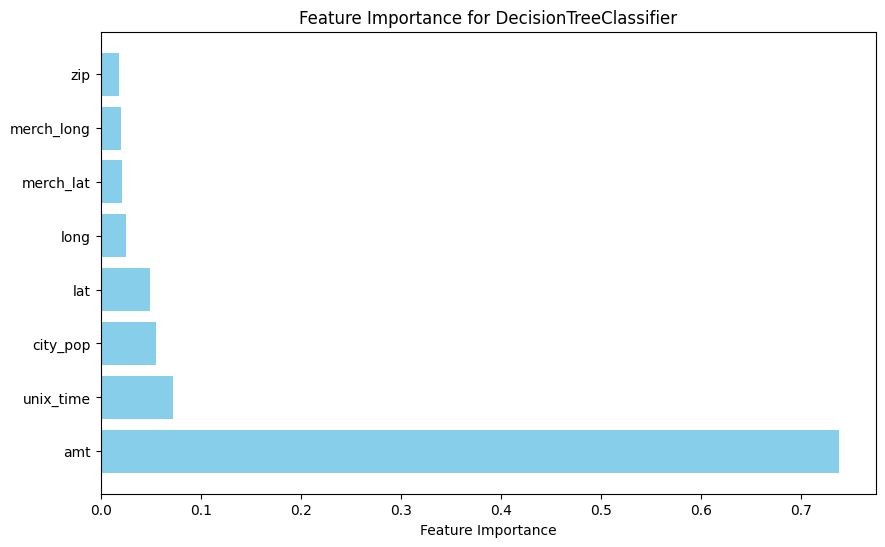

Train eval for LogisticRegression() 

['amt', 'zip', 'lat', 'long', 'city_pop', 'unix_time', 'merch_lat', 'merch_long']
Accuracy: 0.5034819347319347
Recall: 0.6883207356413465
Precision: 0.3822058209785467
F1 Score: 0.4902128653411721
Train eval for RandomForestClassifier() 

['amt', 'zip', 'lat', 'long', 'city_pop', 'unix_time', 'merch_lat', 'merch_long']
Accuracy: 0.9210460372960373
Recall: 0.9067071047205105
Precision: 0.9334125815178261
F1 Score: 0.9198052180666716


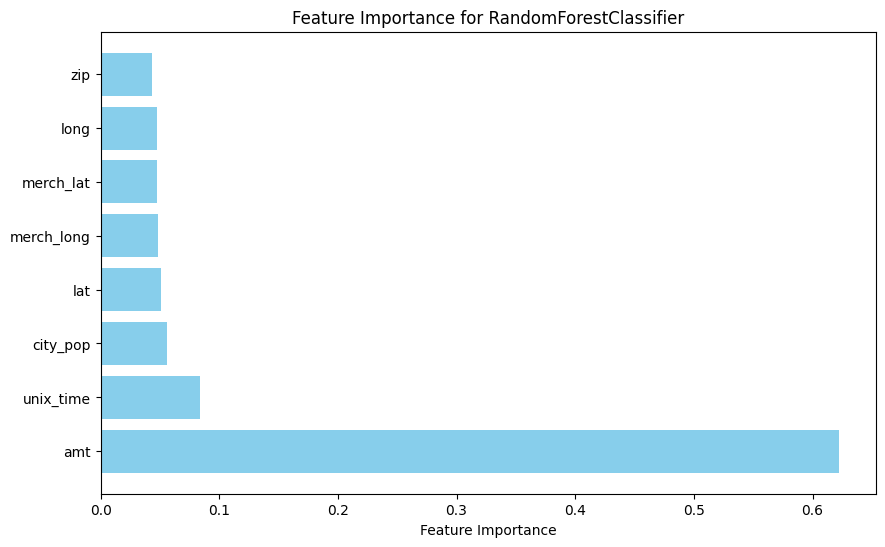

Train eval for GaussianNB() 

['amt', 'zip', 'lat', 'long', 'city_pop', 'unix_time', 'merch_lat', 'merch_long']
Accuracy: 0.8321037296037297
Recall: 0.6846674039882167
Precision: 0.970752792667986
F1 Score: 0.802798131769295


In [35]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, f1_score

def train_no_sample(model):
  acc = []
  rec = []
  prec = []
  f1 = []

  for i in range(200):
    X_train, X_test, y_train, y_test = train_test_split(X_iter_3, y_iter_3, test_size=0.4, random_state=i)

    numerical_columns = [col for col in X_train.columns if X_train[col].dtype in ['int64', 'float64']]

    nominal = [col for col in X_train.columns if X_train[col].dtype == 'object']


    # Create a scaler for numerical features
    # scaler = StandardScaler()
    # X_train_scaled = scaler.fit_transform(X_train[numerical_columns])
    # X_test_scaled = scaler.transform(X_test[numerical_columns])

    categorical_encoder = OrdinalEncoder()
    X_train_categorical = categorical_encoder.fit_transform(X_train[nominal])
    X_test_categorical = categorical_encoder.transform(X_test[nominal])

    X_final_train = np.concatenate((X_train[numerical_columns], X_train_categorical), axis=1)
    X_final_test = np.concatenate((X_test[numerical_columns], X_test_categorical), axis=1)

    model.fit(X_final_train, y_train)

    y_pred = model.predict(X_final_test)

    accuracy = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    f1_s = f1_score(y_test, y_pred)
    acc.append(accuracy)
    rec.append(recall)
    prec.append(precision)
    f1.append(f1_s)

  print(numerical_columns)

  print("Accuracy:", sum(acc) / len(acc))
  print("Recall:", sum(rec)/len(rec))
  print("Precision:", sum(prec)/len(prec))
  print("F1 Score:", sum(f1)/len(f1))


  if hasattr(model, "feature_importances_"):
    feature_importances = model.feature_importances_
    feature_names = X_iter_3.columns

    sorted_idx = np.argsort(feature_importances)
    feature_importances = feature_importances[sorted_idx]
    feature_names = feature_names[sorted_idx]

    plt.figure(figsize=(10, 6))
    plt.barh(range(len(feature_names)), feature_importances, color='skyblue')
    plt.yticks(range(len(feature_names)), feature_names)
    plt.xlabel("Feature Importance")
    plt.title(f"Feature Importance for {model.__class__.__name__}")
    plt.gca().invert_yaxis()
    plt.show()

models = [DecisionTreeClassifier(), LogisticRegression(), RandomForestClassifier(), GaussianNB()]

for model in models:
  print(f'Train eval for {model} \n')
  train_no_sample(model)

#Final findings

In the earlier stages of the first iteration of the CRISP-DM, we tried to use models like SVC, RandomForestClassifier. These models were being extermely slow because we wern't sampling our data.

We were getting amazing accuracy results but low recall. We were introducing data leakage because we were encoding the whole dataframe first and then doing splitting. On the second iteration,  we changed this factor and it seems to improve the performance of the models significantly.

In the second iteration, we got to see how correctly choosing the right steps and sampling methods for our data, we improved model's performance.


Here is the comparision of each model in both iterations:


```
---------------------------------Iteration 1-----------------------------Iteration 2----------------------------------Iteration 3
Model-------------------------Accuracy,Recall---------------------------Accuracy,Recall--------------------------Accuracy,Recall
DecisionTreeClassifier()----0.9886777514,0.002212389381---------------------0.8742424242,0.8829837727--------------0.877,0.875
LogisticRegression()--------0.4962631811,0.5011061947---------------------0.5157634033,0.6199619786--------------0.527389,0.92434
RandomForestClassifier()-----0.6401927529,0.3522211546---------------------0.91643356645,0.8995482-------------0.9254,0.905437
SVC,0.5555180667-------------0.439165866,0.4944347319---------------------0.55-----------------------------------Too slow
Naive Bayes-----------------0.6436447312,0.3513326928---------------------0.8222610723,0.6694405057-----------0.842657,0.699763
```

The final winner from the models is RandomForestClassifier. The fact that the runner up model is DecisionTreeClassifier shows us that when using the ensemble version of the best base model we were able to find the overall best model with an optimal runtime and an amazing recall score.


In [36]:
import pickle

with open("model.pkl", "wb") as f:
  pickle.dump(models[2], f)

#Deployment

The deployment is done by exporting the model and loading it up in a flask app. The app is leveraging this model to provide an API that other businesses or project can use for detecting the transactions.

#Prepared By



*   Rediet Dejene         20016660
*   Preethi Manoharan     20025478
*   Nagapriya Ganapathy   20019930


